In [1]:
from paretoKnapsackTeams import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

#Import datasets
#IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, imdb_graphmat_1 = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, imdb_graphmat_2 = import_pickled_datasets('imdb', 2)
# imdb_experts_3, imdb_tasks_3, imdb_costs_3, imdb_graphmat_3 = import_pickled_datasets('imdb', 3)

#Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, bbsm_graphmat_1 = import_pickled_datasets('bbsm', 1)
# bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, bbsm_graphmat_2 = import_pickled_datasets('bbsm', 2)
# bbsm_experts_3, bbsm_tasks_3, bbsm_costs_3, bbsm_graphmat_3 = import_pickled_datasets('bbsm', 3)

#Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, fl_graphmat_1 = import_pickled_datasets('freelancer', 1)
# fl_experts_2, fl_tasks_2, fl_costs_2, fl_graphmat_2 = import_pickled_datasets('freelancer', 2)

2026-02-02 16:52:28,378 |INFO: Imported imdb experts, Num Experts: 200
2026-02-02 16:52:28,379 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-02 16:52:28,380 |INFO: Imported imdb costs, Num Costs: 200
2026-02-02 16:52:28,384 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-02-02 16:52:28,385 |INFO: Imported imdb experts, Num Experts: 400
2026-02-02 16:52:28,386 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-02 16:52:28,387 |INFO: Imported imdb costs, Num Costs: 400
2026-02-02 16:52:28,392 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-02-02 16:52:28,394 |INFO: Imported bbsm experts, Num Experts: 250
2026-02-02 16:52:28,395 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-02-02 16:52:28,395 |INFO: Imported bbsm costs, Num Costs: 250
2026-02-02 16:52:28,399 |INFO: Imported bbsm graph matrix, Shape: (500, 500)

2026-02-02 16:52:28,403 |INFO: Imported freelancer experts, Num Experts: 50
2026-02-02 16:52:28,404 |INFO: Imported freelancer tasks, Num Tasks: 25

### Average Plotting across Tasks

In [ ]:
def findApproximateParetoSolutions(tasks_list, experts_list, costs_list,
                                   sizeUniverse, numExperts, numTasks, maxBudget,
                                   dataset_name=None):
    '''
    Run algorithms over multiple tasks, aggregate results, and plot mean +/- std.
    '''
    # Cost grid (same for all tasks)
    num_steps, min_cost = 15, 5
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    # algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-1", "ParetoGreedy-2"]
    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "CoverageLinear", "TopK"]

    def align_to_cost_arr(costs, covs):
        if len(costs) == 0:
            return np.zeros_like(cost_arr, dtype=float)
        costs = np.array(costs, dtype=float)
        covs = np.array(covs, dtype=float)
        return np.interp(cost_arr, costs, covs, left=covs[0], right=covs[-1])

    # containers across tasks
    all_coverages = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_points_counts = []
    pareto_k_counts = []
    pareto_costs_all = []

    # iterate tasks
    for task_index in range(numTasks):
        # per-task containers (will be appended to across budgets)
        imdb_coverages = {alg: [] for alg in algo_names}
        imdb_costs = {alg: [] for alg in algo_names}
        imdb_runtimes = {alg: [] for alg in algo_names}

        # Prefix Pareto (computed once per task at full budget)
        paretoTeams_full = paretoKnapsackTeams(task=tasks_list[task_index],
                                          n_experts=experts_list[:numExperts],
                                          costs=costs_list, size_univ=sizeUniverse,
                                          budget=maxBudget)
        pp1_costs, pp1_coverages, pp1_map, pp1_time = paretoTeams_full.prefixParetoGreedy_1Guess()
        # pp2_costs, pp2_coverages, _, pp2_time = paretoTeams_full.prefixParetoGreedy_2Guess()

        # Coverage Linear (computed once per task at full budget)
        cl_costs, cl_coverages, cl_map, cl_time = paretoTeams_full.coverage_linear()

        # Interpolate prefix pareto and coverage linear to the shared cost grid
        imdb_coverages['ParetoGreedy-Knapsack'] = list(align_to_cost_arr(pp1_costs, pp1_coverages))
        imdb_coverages['CoverageLinear'] = list(align_to_cost_arr(cl_costs, cl_coverages))
        imdb_runtimes['ParetoGreedy-Knapsack'].append(pp1_time)
        imdb_runtimes['CoverageLinear'].append(cl_time)
        pareto_points_counts.append(len(pp1_costs))
        pareto_costs_all.extend(pp1_costs)
        if len(pp1_costs) > 0:
            expert_counts = [len(pp1_map[b][1]) for b in pp1_costs if b in pp1_map]
            mean_pareto_k = int(np.round(np.mean(expert_counts))) if len(expert_counts) > 0 else 1
        else:
            mean_pareto_k = 1
        mean_pareto_k = max(1, min(numExperts, mean_pareto_k))
        pareto_k_counts.append(mean_pareto_k)

        for budgetVal in cost_arr:
            # Initialize Pareto teams object
            paretoTeams = paretoKnapsackTeams(task=tasks_list[task_index],
                                         n_experts=experts_list[:numExperts],
                                         costs=costs_list, size_univ=sizeUniverse,
                                         budget=budgetVal)

            # Plain Greedy
            plainExperts, _, plainCov, plainCost, plainTime = paretoTeams.plainGreedy()
            imdb_coverages['PlainGreedy'].append(plainCov)
            imdb_costs['PlainGreedy'].append(plainCost)
            imdb_runtimes['PlainGreedy'].append(plainTime)

            # # Greedy Plus
            # # _, _, gpCov, gpCost, gpTime = paretoTeams.greedyPlus()
            # # imdb_coverages['GreedyPlus'].append(gpCov)
            # # imdb_costs['GreedyPlus'].append(gpCost)
            # # imdb_runtimes['GreedyPlus'].append(gpTime)

            # Two Guess Plain Greedy
            _, _, tgCov, tgCost, tgTime = paretoTeams.twoGuessPlainGreedy()
            imdb_coverages['PlainGreedy-2Guess'].append(tgCov)
            imdb_costs['PlainGreedy-2Guess'].append(tgCost)
            imdb_runtimes['PlainGreedy-2Guess'].append(tgTime)

            # One Guess Greedy Plus
            _, _, ogCov, ogCost, ogTime = paretoTeams.oneGuessGreedyPlus()
            imdb_coverages['GreedyPlus-1Guess'].append(ogCov)
            imdb_costs['GreedyPlus-1Guess'].append(ogCost)
            imdb_runtimes['GreedyPlus-1Guess'].append(ogTime)

            # Top-k (use #experts chosen by PlainGreedy)
            k_val = max(1, len(plainExperts))
            _, _, tkCov, tkCost, tkTime = paretoTeams.top_k(k_val)
            imdb_coverages['TopK'].append(tkCov)
            imdb_costs['TopK'].append(tkCost)
            imdb_runtimes['TopK'].append(tkTime)

        # convert per-task lists to numpy arrays and store in all_coverages
        for alg in algo_names:
            arr = np.array(imdb_coverages[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_coverages[alg].append(arr)
            runtimes = imdb_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across tasks for each algorithm
    mean_coverages = {}
    std_coverages = {}
    for alg in algo_names:
        stacked = np.vstack(all_coverages[alg])  # shape (numTasks, len(cost_arr))
        mean_coverages[alg] = np.mean(stacked, axis=0)
        std_coverages[alg] = np.std(stacked, axis=0)*0.5

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    # Plot mean coverage with shaded std band
    # colors = cm.viridis(np.linspace(0.05, 0.85, len(algo_names)))
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_coverages[alg]
        std = std_coverages[alg]*0.5
        is_pareto = alg in {"ParetoGreedy-Knapsack", "ParetoGreedy-2"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-2":
            marker = "x"
            zorder = 5
        elif alg == "ParetoGreedy-Knapsack":
            marker = "D"
            zorder = 4
        elif alg == "TopK":
            marker = "D"

        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_costs_unique = np.unique(np.array(pareto_costs_all, dtype=float))
            pareto_costs_unique = pareto_costs_unique[(pareto_costs_unique >= cost_arr.min()) & (pareto_costs_unique <= cost_arr.max())]
            if pareto_costs_unique.size > 0:
                keep_count = max(1, int(np.ceil(pareto_costs_unique.size * 0.75)))
                keep_idx = rng.choice(pareto_costs_unique.size, size=keep_count, replace=False)
                pareto_costs_unique = np.sort(pareto_costs_unique[keep_idx])
                min_sep = 0.5 * (cost_arr[1] - cost_arr[0]) if cost_arr.size > 1 else 0
                filtered_costs = [pareto_costs_unique[0]]
                for c in pareto_costs_unique[1:]:
                    if c - filtered_costs[-1] >= min_sep:
                        filtered_costs.append(c)
                pareto_costs_unique = np.array(filtered_costs, dtype=float)
            pareto_mean_vals = np.interp(pareto_costs_unique, cost_arr, mean)
            ax.scatter(pareto_costs_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            if alg == "ParetoGreedy-Knapsack":
                from matplotlib.lines import Line2D
                pareto_legend_handle = Line2D([0], [0],
                                              color=color,
                                              linestyle=line_style,
                                              marker=marker,
                                              markersize=marker_size,
                                              markeredgewidth=1.1,
                                              markeredgecolor='k',
                                              linewidth=1.8)
        else:
            ax.plot(cost_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, 1),
                        np.clip(mean + std, 0, 1),
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Team cost, $c_\ell$', fontsize=28)
    ax.set_ylabel(r'Task coverage, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handle_map = dict(zip(labels, handles))
        pareto_label = label_map.get("ParetoGreedy-Knapsack")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        ordered_labels = []
        if pareto_label:
            ordered_labels.append(pareto_label)
        ordered_labels.extend([label_map[alg] for alg in algo_names if alg != "ParetoGreedy-Knapsack"]
        )
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF (only once)
    if handles:
        legend_out_path = plots_dir / "knapsack_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=3, fontsize=20, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

## Freelancer-1

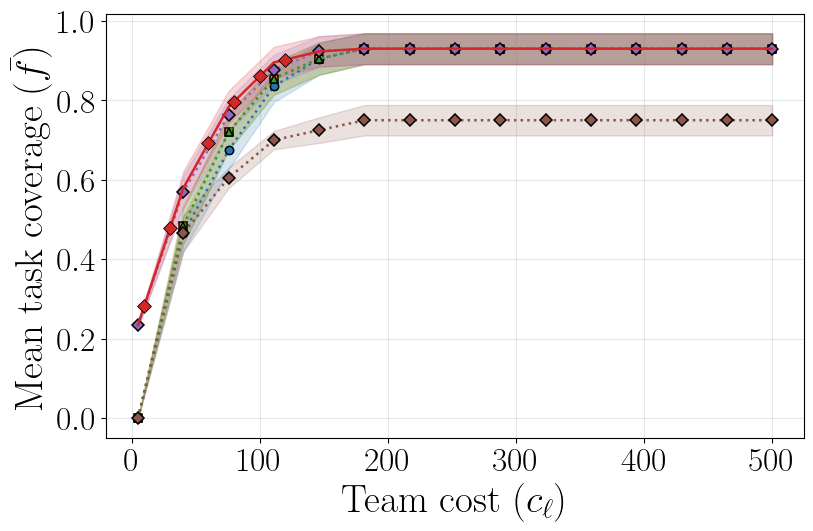

2026-02-02 16:52:50,253 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.002 ± 0.001
  - PlainGreedy-2Guess: 1.868 ± 0.469
  - GreedyPlus-1Guess: 0.237 ± 0.048
  - ParetoGreedy-Knapsack: 0.007 ± 0.003
  - CoverageLinear: 0.000 ± 0.000
  - TopK: 0.001 ± 0.000


In [3]:
findApproximateParetoSolutions(tasks_list=fl_tasks_1, experts_list=fl_experts_1, costs_list=fl_costs_1,
                               sizeUniverse=50, numExperts=50, numTasks=10, maxBudget=500,
                               dataset_name="Freelancer")

## IMDB

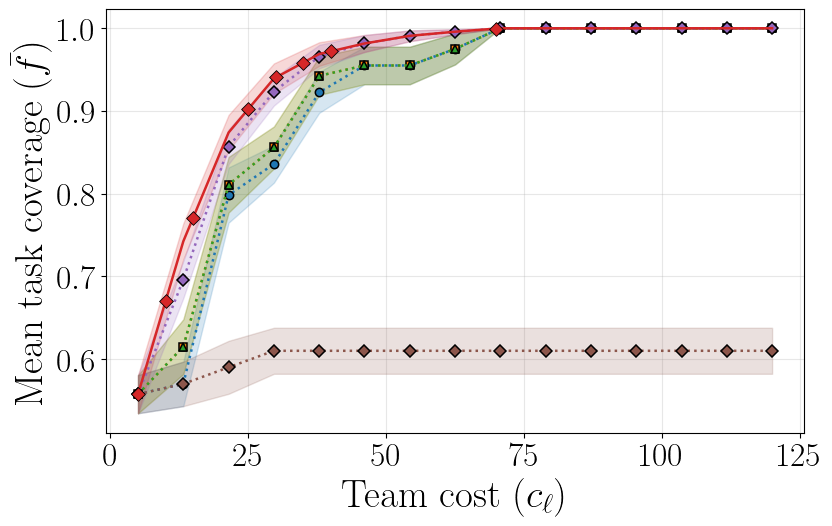

2026-02-02 16:53:45,418 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.010 ± 0.003
  - PlainGreedy-2Guess: 4.898 ± 0.824
  - GreedyPlus-1Guess: 0.517 ± 0.074
  - ParetoGreedy-Knapsack: 0.047 ± 0.010
  - CoverageLinear: 0.001 ± 0.000
  - TopK: 0.001 ± 0.000


In [4]:
findApproximateParetoSolutions(tasks_list=imdb_tasks_1, experts_list=imdb_experts_1, costs_list=imdb_costs_1,
                               sizeUniverse=24, numExperts=150, numTasks=10, maxBudget=120,
                               dataset_name="IMDB-1")

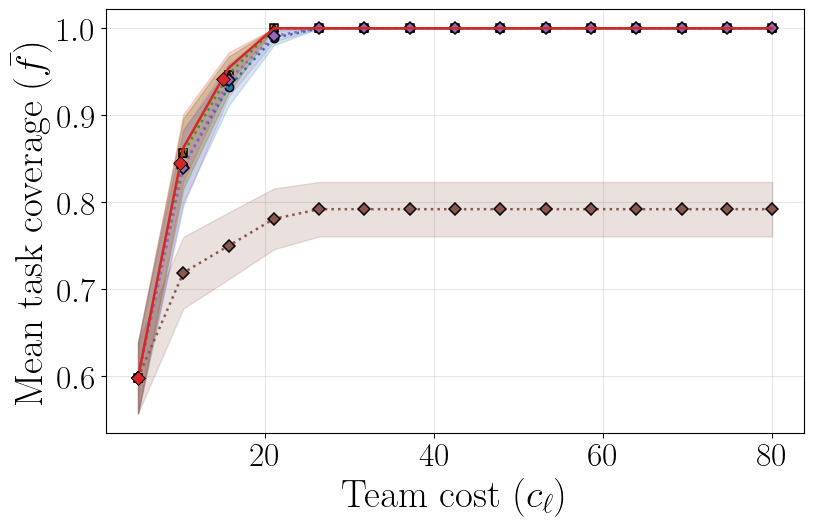

2026-02-02 16:55:36,062 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.009 ± 0.003
  - PlainGreedy-2Guess: 10.045 ± 1.518
  - GreedyPlus-1Guess: 0.876 ± 0.164
  - ParetoGreedy-Knapsack: 0.071 ± 0.016
  - CoverageLinear: 0.002 ± 0.001
  - TopK: 0.002 ± 0.000


In [5]:
findApproximateParetoSolutions(tasks_list=imdb_tasks_2, experts_list=imdb_experts_2, costs_list=imdb_costs_2,
                               sizeUniverse=24, numExperts=300, numTasks=10, maxBudget=80,
                               dataset_name="IMDB-2")

## Bbsm-1

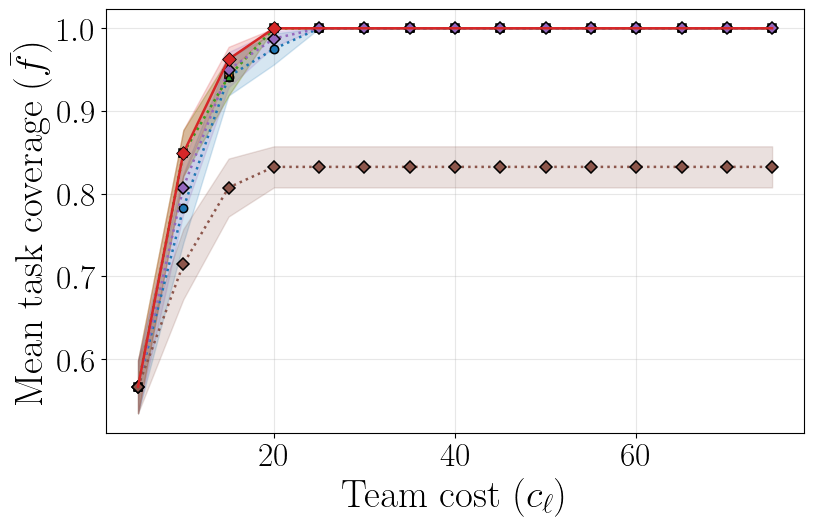

2026-02-02 16:57:16,099 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.009 ± 0.003
  - PlainGreedy-2Guess: 8.946 ± 0.880
  - GreedyPlus-1Guess: 0.913 ± 0.119
  - ParetoGreedy-Knapsack: 0.064 ± 0.010
  - CoverageLinear: 0.002 ± 0.001
  - TopK: 0.002 ± 0.000


In [6]:
findApproximateParetoSolutions(tasks_list=bbsm_tasks_1, experts_list=bbsm_experts_1, costs_list=bbsm_costs_1,
                               sizeUniverse=75, numExperts=250, numTasks=10, maxBudget=75,
                               dataset_name="Bbsm")